<a href="https://colab.research.google.com/github/mmasdar/end-to-end-dental-disease/blob/main/Ensemble_DL_Model_for_Dental_Diagnosis_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mounting Dataset
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Generate Blurr Image as Input

Blurred image saved successfully at: /content/blurred_image.jpg


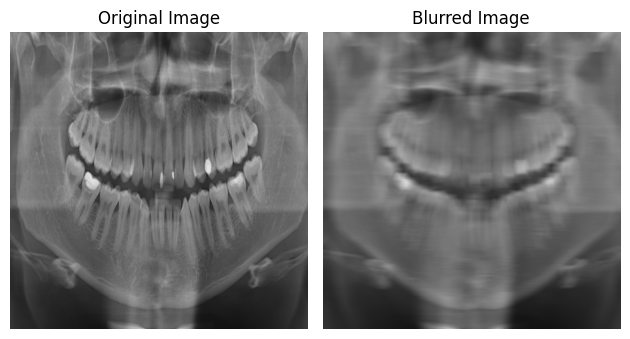

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def motion_blur_horizontal(image, kernel_size):
    # Create the horizontal kernel.
    kernel_h = np.zeros((kernel_size, kernel_size))
    # Fill the middle row with ones.
    kernel_h[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
    # Normalize.
    kernel_h /= kernel_size

    # Perform convolution using the horizontal kernel.
    blurred_image = cv2.filter2D(image, -1, kernel_h)

    return blurred_image

# Load the original image
image = cv2.imread('/content/cate2-00016.jpg')

# Specify the kernel size for motion blur
kernel_size = 20

# Perform motion blur in the horizontal direction
blurred_image = motion_blur_horizontal(image, kernel_size)

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Display the blurred image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
plt.title('Blurred Image')
plt.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the blurred image
output_path = '/content/blurred_image.jpg'
cv2.imwrite(output_path, blurred_image)
print(f"Blurred image saved successfully at: {output_path}")

# Show the plot
plt.show()

## System for X-ray

1/1 [==============================] - 3s 3s/step


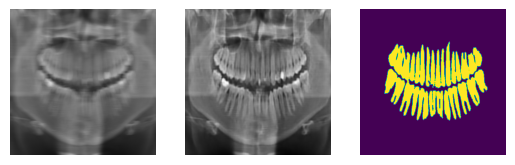

In [35]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

class ImageProcessor:
    def __init__(self, pix2pix_model_path, segmentation_model_path):
        self.pix2pix_model = keras.models.load_model(pix2pix_model_path)
        self.segmentation_model = self.load_segmentation_model(segmentation_model_path)

    @staticmethod
    def preprocess_input(input_image):
        input_image = tf.cast(input_image, tf.float32)
        input_image = (input_image / 127.5) - 1.0  # Normalize between -1 and 1
        return input_image

    @staticmethod
    def dice_coef(y_true, y_pred):
        smooth = K.epsilon()
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + smooth)

    @staticmethod
    def dice_coef_loss(y_true, y_pred):
        return 1.0 - ImageProcessor.dice_coef(y_true, y_pred)

    @staticmethod
    def bce_dice_loss(y_true, y_pred):
        loss = keras.losses.binary_crossentropy(y_true, y_pred) + ImageProcessor.dice_coef_loss(y_true, y_pred)
        return loss

    @staticmethod
    def get_custom_objects():
        return {"bce_dice_loss": ImageProcessor.bce_dice_loss, "dice_coef": ImageProcessor.dice_coef}

    def load_segmentation_model(self, segmentation_model_path):
        with keras.utils.custom_object_scope(self.get_custom_objects()):
          custom_objects = {"bce_dice_loss": bce_dice_loss, "diceCoef": diceCoef}
          model = load_model(segmentation_model_path, custom_objects=custom_objects)
        return model

    def generate_image(self, input_image_path, output_image_path):
        # Load and process the input image for generation
        input_data = keras.preprocessing.image.load_img(input_image_path, target_size=(512, 512))
        input_data = keras.preprocessing.image.img_to_array(input_data)

        # Preprocess the input data
        input_data = self.preprocess_input(input_data)

        # Add batch dimension and expand dimensions for model input
        input_data = tf.expand_dims(input_data, axis=0)

        # Generate output using Pix2Pix model
        generated_image = self.pix2pix_model.predict(input_data)
        generated_image = np.squeeze(generated_image, axis=0)
        generated_image = (generated_image + 1.0) * 127.5  # De-normalize

        # Save the generated output image
        keras.preprocessing.image.save_img(output_image_path, generated_image)

        return generated_image

    def segment_image(self, input_image_path, output_image_path):
        # Load and preprocess the input image for segmentation
        input_image = Image.open(input_image_path)
        input_image = input_image.resize((512, 512))
        input_image = np.array(input_image)
        input_image = np.expand_dims(input_image, axis=0)
        input_image = input_image / 255.0

        # Perform segmentation
        seg_map = self.segmentation_model.predict(input_image)
        seg_map = np.squeeze(seg_map)
        seg_map = np.argmax(seg_map, axis=-1)

        # Save the segmentation map as an image
        output_image = Image.fromarray(seg_map.astype(np.uint8))
        output_image.save(output_image_path)

        return seg_map

    def process_image(self, input_image_path, generated_image_path, segmented_image_path):
        # Generate image using Pix2Pix
        generated_image = self.generate_image(input_image_path, generated_image_path)

        # Perform segmentation on the generated image
        segmentation_map = self.segment_image(generated_image_path, segmented_image_path)

        # Display the processed images
        input_img = Image.open(input_image_path)
        generated_img = Image.open(generated_image_path)
        segmented_img = Image.open(segmented_image_path)

        plt.subplot(1, 3, 1)
        plt.imshow(input_img)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(generated_img)
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(segmented_img)
        plt.axis('off')

        plt.show()

# Example usage
input_image_path = '/content/blurred_image.jpg'
generated_image_path = '/content/generated_image.jpg'
segmented_image_path = '/content/segmented_image.png'
pix2pix_model_path = '/content/gdrive/MyDrive/Dental Disease/Trained Model/xray - Generative Model - pix2pix/pix2pix_generator_model_DentalXray.h5'
segmentation_model_path = '/content/gdrive/MyDrive/Dental Disease/Trained Model/segmentation-xray-all tooth/dental_unet.h5'

image_processor = ImageProcessor(pix2pix_model_path, segmentation_model_path)
image_processor.process_image(input_image_path, generated_image_path, segmented_image_path)